In [313]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 10)

from numba import jit
from collections import namedtuple

Let's generate a random field

In [416]:
N = 100
ndim = 1
np.random.seed(16091992)
data_raw = np.random.rand(*[N]*ndim)

In [417]:
filter_size = N / 5

Extracting gradients + hessian

In [418]:
kall = [np.fft.fftfreq(_) for _ in data_raw.shape[:-1]] + [np.fft.rfftfreq(_) for _ in data_raw.shape[-1:]]
kgrid = np.asarray(np.meshgrid(*kall, indexing='ij'))
k2 = (kgrid**2).sum(axis=0)

Perform analysis in Fourier space, so that it's easy to smooth the data!

In [419]:
%%time
dataraw_f = np.fft.rfftn(data_raw)
data_f = np.exp(-k2 * filter_size**2) * dataraw_f
data_smoothed = np.fft.irfftn(data_f)

CPU times: user 2.57 ms, sys: 238 µs, total: 2.81 ms
Wall time: 2.17 ms


Text(0.5,1,'ndim=1')

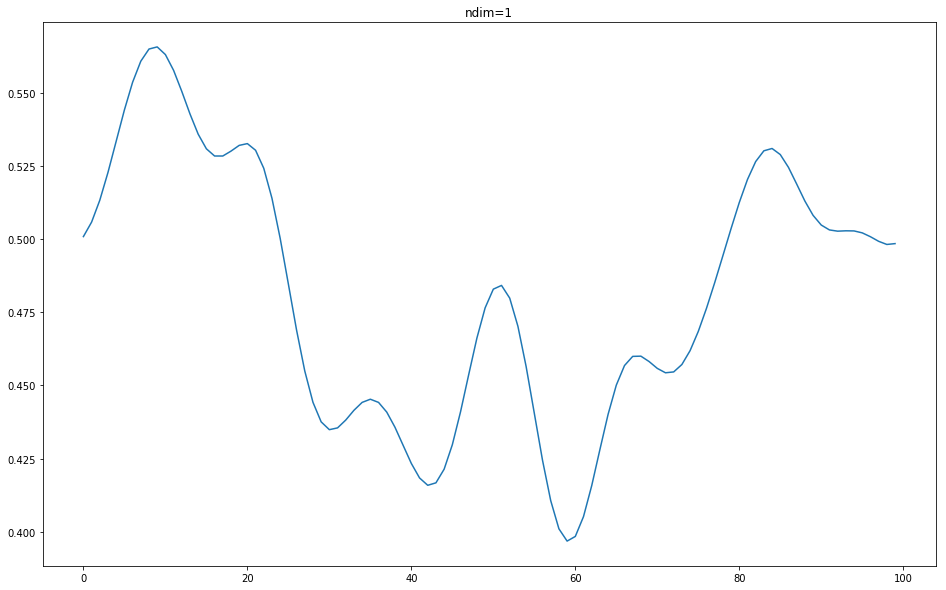

In [420]:
if ndim == 1:
    plt.plot(data_smoothed)
elif ndim == 2:
    plt.imshow(data_smoothed)
elif ndim == 3:
    plt.imshow(data_smoothed[N//2, ...])
    
plt.title(rf'ndim={ndim}')

In [421]:
%%time
grad_f = np.zeros([ndim] + list(data_f.shape), dtype=data_f.dtype)
hess_f = np.zeros([ndim*(ndim+1)//2] + list(data_f.shape), dtype=data_f.dtype)

indices = np.zeros((ndim, ndim), dtype=int)
ihess = 0
for idim in range(ndim):
    grad_f[idim, ...] = data_f * (1j) * kgrid[idim]
    for idim2 in range(idim, ndim):
        hess_f[ihess, ...] = grad_f[idim, ...] * (1j) * kgrid[idim2]
        indices[idim, idim2] = indices[idim2, idim] = ihess
        ihess += 1

CPU times: user 341 µs, sys: 181 µs, total: 522 µs
Wall time: 410 µs


Get back real components

In [432]:
%%time
grad = np.zeros([ndim] + list(data_smoothed.shape), dtype=data_smoothed.dtype)
hess = np.zeros([ndim*(ndim+1)//2] + list(data_smoothed.shape), dtype=data_smoothed.dtype)
grad[...] = np.fft.irfftn(grad_f, axes=range(1, len(grad_f.shape))) * (2*np.pi)
hess[...] = np.fft.irfftn(hess_f, axes=range(1, len(grad_f.shape))) * (2*np.pi)**2

CPU times: user 647 µs, sys: 0 ns, total: 647 µs
Wall time: 669 µs


Now solving equation
$$
\nabla \rho(x) = 0 = \nabla \rho(x_0) + \Delta x \nabla\nabla \rho(x_0)
$$
which is equivalent to solving
$$
\Delta x = -\rho(x_0) \left|\nabla\nabla \rho(x_0)\right|^{-1}.
$$

In [433]:
rhs = -grad
lhs = hess[indices.flatten(), ...].reshape(ndim, ndim, *data_raw.shape)

In [434]:
CritPoints = namedtuple('CriticalPoints', ['pos', 'eigvals', 'kind'])

In [435]:
xyz_rel = np.linalg.solve(lhs.T, rhs.T).T
j = 0

#@jit
def copy_xyz(xyz_rel):
    shape = xyz_rel.shape[1:]

    ndim = xyz_rel.shape[0]
    xyz_copy = xyz_rel.reshape(ndim, -1)
    
    N = xyz_copy.shape[1]

    count = 0
    for ii in range(N):
        ok = True
        for idim in range(ndim):
            ok &= -1 < xyz_copy[idim, ii] < 1
            
        if ok:
            count += 1
      
    xyz = np.zeros((ndim, count), dtype=xyz_rel.dtype)
    mask = np.zeros(N, dtype=bool)

    count = 0
    for ii in range(N):
        ok = True
        for idim in range(ndim):
            ok &= -1 < xyz_copy[idim, ii] < 1
        mask[ii] = ok
        if ok:
            ijk = list(np.unravel_index(ii, shape))
            for idim in range(ndim):
                xyz[idim, count] = ijk[idim]
            xyz[:, count] += xyz_copy[:, ii]
            count += 1
            
    return xyz, mask
            
xyz, mask = copy_xyz(xyz_rel)
loc_hess = hess.reshape(ndim*(ndim+1)//2, -1)[indices.flatten()][:, mask].reshape(ndim, ndim, -1).T

CritPoints = namedtuple('CriticalPoints', ['pos', 'eigvals', 'kind', 'hessian', 'N'])
data = CritPoints(
    N = xyz.shape[1],
    pos = xyz,
    eigvals = np.linalg.eigvalsh(loc_hess),
    hessian = loc_hess,
    kind = (eigvals > 0).sum(axis=1)
)
labels = {}
for k in range(ndim+1):
    if k == 0:
        labels[k] = 'max'
    elif k == ndim:
        labels[k] = 'min'
    else:
        labels[k] = f'saddle.{k}'

In [436]:
@jit
def distance2(a, b, N):
    d2 = 0
    for i in range(a.shape[0]):
        aa = a[i]
        bb = b[i]
        if aa - bb < -N/2:
            d2 += (aa - bb + N)**2
        elif aa - bb > N/2:
            d2 += (aa - bb - N)**2
        else:
            d2 += (aa - bb)**2
    return d2
     
@jit
def cleanup_pairs(xyz, kind):
    tmp = np.zeros([N]*ndim, dtype=np.int32)
    ijk = [(0,)]*ndim
    mask = np.zeros(tmp.shape, dtype=bool)

    Nextr = xyz.shape[1]
    for inew in range(Nextr):
        pos = xyz[:, inew]
        for idim in range(ndim):
            ijk[idim] = (int((np.round(xyz[idim, inew]))) % N, )

        # Get index of old value
        iold = tmp[ijk]
        if iold > 0:
            oldpos = xyz[:, iold]
            # Old is closer than old, keep new
            if distance2(oldpos, ijk, N) > distance2(pos, ijk, N) and kind[inew] == kind[iold]:
                # print("replacing older", iold, 'at position,', oldpos.flatten(), 'with', inew, 'at position', pos)
                tmp[ijk] = inew
        else:
            tmp[ijk] = inew
    indexes = tmp[tmp>0]
    return indexes, xyz[:, indexes]

idclean, xclean = cleanup_pairs(data.pos, data.kind)
dataclean = CritPoints(
    xclean, data.eigvals[idclean, ...], data.kind[idclean], N, data.hessian[idclean, ...]
)

## Checks for 2D

(0, 100)

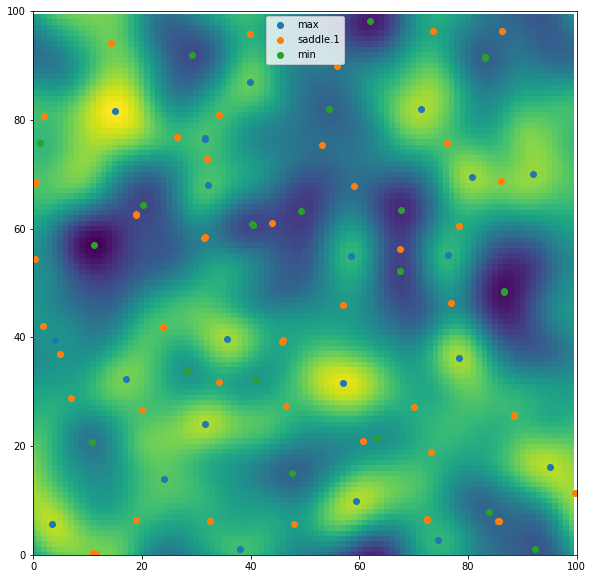

In [407]:
interp = scipy.interpolate.interp1d(np.arange(len(data_smoothed)), data_smoothed[N//2])
plt.imshow(data_smoothed.T)
for k in range(ndim+1):
    m = (dataclean.kind == k)
    plt.plot(*dataclean.pos[:, m], 'o', label=labels[k])
plt.legend()
plt.xlim(0, N)
plt.ylim(0, N)

Check the gradient & hessian are correctly computed

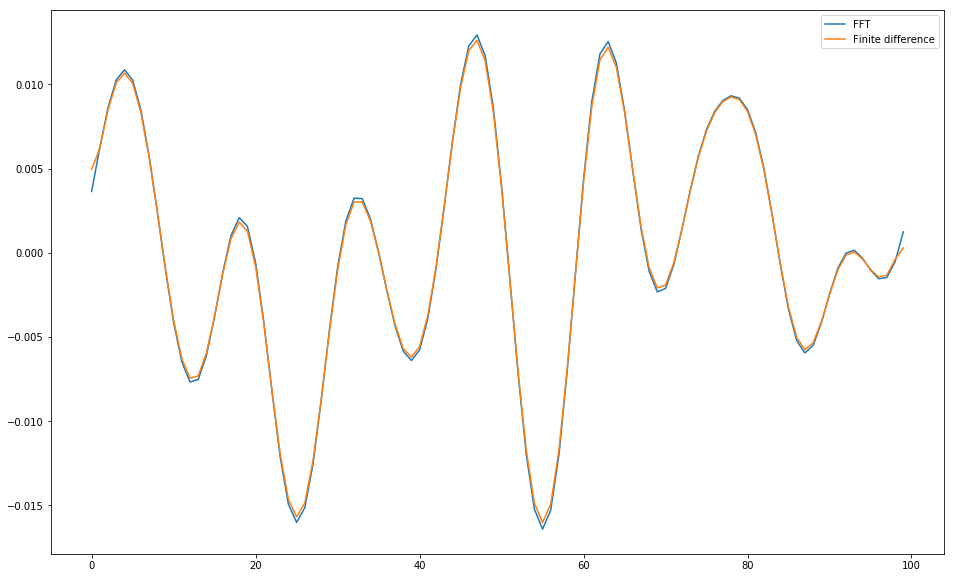

In [209]:
plt.plot(grad[0], label='FFT')
plt.plot(np.gradient(data_smoothed), label='Finite difference')
plt.legend()

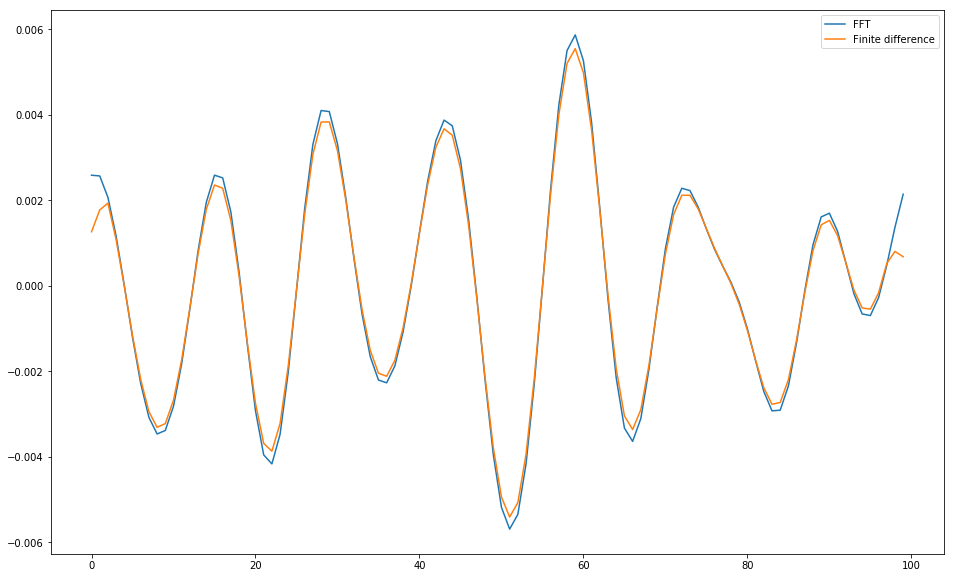

In [210]:
plt.plot(hess[0], label='FFT')
plt.plot(np.gradient(np.gradient(data_smoothed)), label='Finite difference')
plt.legend()

## Checks for 1D

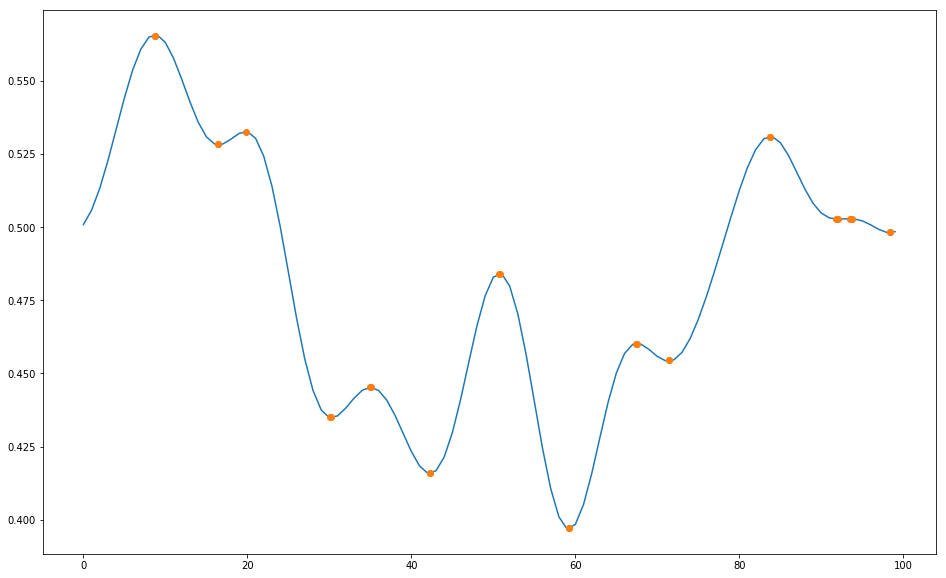

In [437]:
interp = scipy.interpolate.interp1d(np.arange(len(data_smoothed)), data_smoothed)
plt.plot(data_smoothed)
plt.plot(xyz.T, interp(xyz.T), 'o')

Check the gradient & hessian are correctly computed

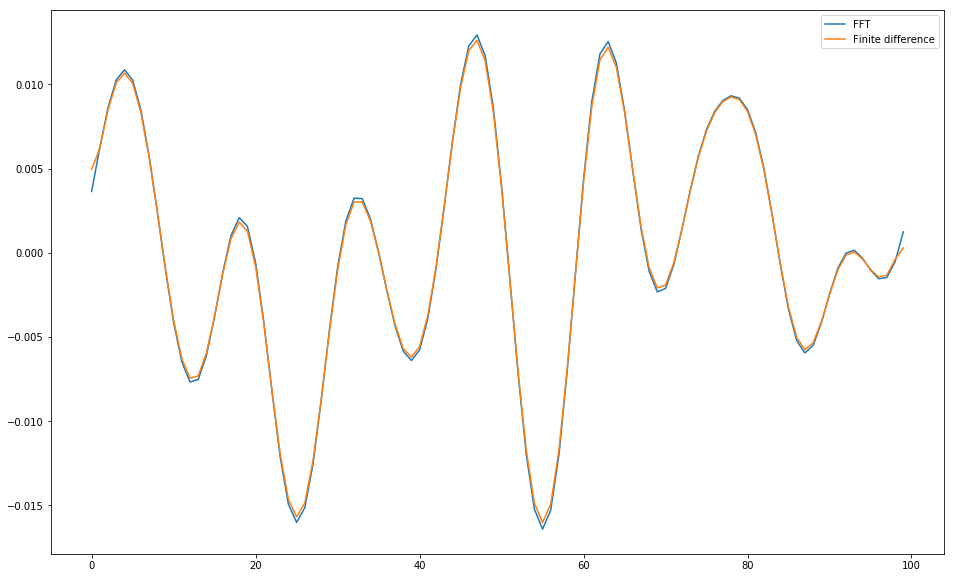

In [438]:
plt.plot(grad[0], label='FFT')
plt.plot(np.gradient(data_smoothed), label='Finite difference')
plt.legend()

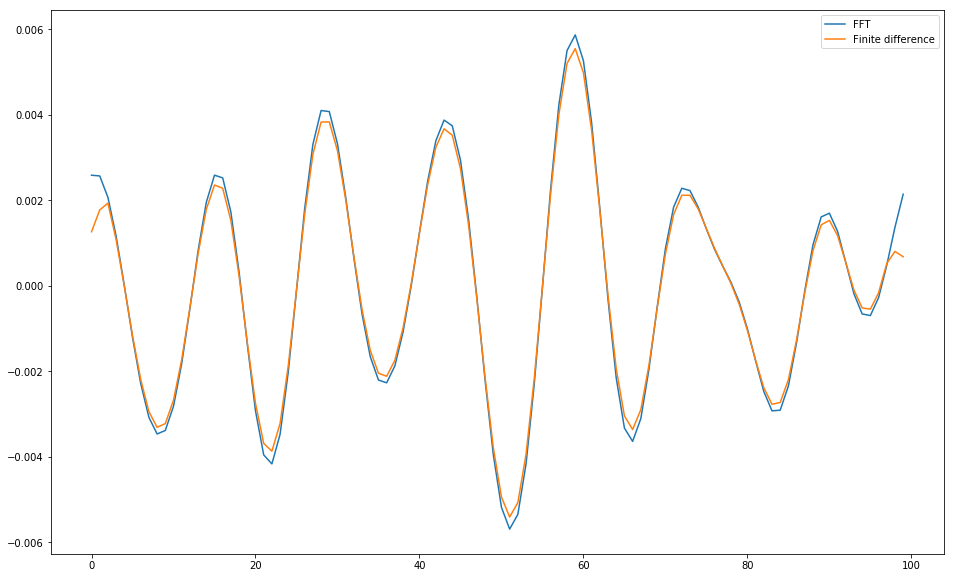

In [439]:
plt.plot(hess[0], label='FFT')
plt.plot(np.gradient(np.gradient(data_smoothed)), label='Finite difference')
plt.legend()